# Homework Assignment 2 – Part 3

## Loading and preparing data

In [556]:
import pandas as pd
import numpy as np

In [557]:
aisles = pd.read_parquet('aisles.parquet', engine='pyarrow')
baskets = pd.read_parquet('baskets.parquet', engine='pyarrow')
departments = pd.read_parquet('departments.parquet', engine='pyarrow')
orders = pd.read_parquet('orders.parquet', engine='pyarrow')
prediction_index = pd.read_parquet('prediction_index.parquet', engine='pyarrow')
products = pd.read_parquet('products.parquet', engine='pyarrow')

In [558]:
pd.set_option('display.max_rows', 10)

### Adding features

In [559]:
orders['reorder_within_14_days'] = (orders['days_since_prior_order'] <= 14).astype(int).shift(-1).fillna(0)
b = baskets.groupby('order_id').count().reset_index()
orders['basket_size'] = b['product_id']
s = baskets.groupby('order_id').mean('reordered').reset_index()
orders['reorder_share'] = s['reordered']
orders

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,reorder_within_14_days,basket_size,reorder_share
0,2539329,1,1,2,8,NaN,0.0,9,0.666667
1,2398795,1,2,3,7,15.0,0.0,8,1.000000
2,473747,1,3,3,12,21.0,0.0,13,0.923077
3,2254736,1,4,4,7,29.0,0.0,26,0.807692
4,431534,1,5,4,15,28.0,0.0,3,0.000000
...,...,...,...,...,...,...,...,...,...
3214869,2558525,206209,9,4,15,22.0,0.0,1,0.000000
3214870,2266710,206209,10,5,18,29.0,0.0,9,0.444444
3214871,1854736,206209,11,4,10,30.0,0.0,7,0.000000
3214872,626363,206209,12,1,12,18.0,1.0,7,0.571429


### Splitting into most recent order and older orders

In [560]:
latest_orders = orders.sort_values('order_number').groupby('user_id').tail(1).copy().sort_values('user_id')
latest_orders = latest_orders.drop(columns = ['days_since_prior_order', 'reorder_within_14_days'])
latest_orders = latest_orders.rename(columns = {'order_hour_of_day' : 'order_hour'})
latest_orders

,order_id,user_id,order_number,order_dow,order_hour,basket_size,reorder_share
9,2550362,1,10,4,8,5,1.000000
23,839880,2,14,3,10,8,0.250000
35,1402502,3,12,1,15,2,1.000000
40,2557754,4,5,5,13,20,0.500000
44,157374,5,4,1,18,7,0.428571
...,...,...,...,...,...,...,...
3214728,414137,206205,3,5,16,4,0.250000
3214795,1904200,206206,67,0,13,17,0.705882
3214811,1005822,206207,16,2,7,7,0.285714
3214860,1882108,206208,49,1,22,12,0.916667


In [561]:
old_orders = orders.copy()
old_orders.drop(latest_orders.index, inplace=True)
old_orders = old_orders.drop(columns = 'days_since_prior_order')
old_orders = old_orders.rename(columns = {'reorder_within_14_days' : 'y', 'order_hour_of_day' : 'order_hour'})
old_orders

,order_id,user_id,order_number,order_dow,order_hour,y,basket_size,reorder_share
0,2539329,1,1,2,8,0.0,9,0.666667
1,2398795,1,2,3,7,0.0,8,1.000000
2,473747,1,3,3,12,0.0,13,0.923077
3,2254736,1,4,4,7,0.0,26,0.807692
4,431534,1,5,4,15,0.0,3,0.000000
...,...,...,...,...,...,...,...,...
3214868,2129269,206209,8,3,17,0.0,9,0.777778
3214869,2558525,206209,9,4,15,0.0,1,0.000000
3214870,2266710,206209,10,5,18,0.0,9,0.444444
3214871,1854736,206209,11,4,10,0.0,7,0.000000




## Logistic regression

In [562]:
import sklearn.linear_model
import statsmodels.api as sm
from sklearn import metrics
import matplotlib.pyplot as plt

In [563]:
old_orders.groupby('y').mean()

,order_id,user_id,order_number,order_dow,order_hour,basket_size,reorder_share
y,,,,,,,
0.0,1.710328e+06,103061.385915,8.422586,2.759520,13.695532,10.092463,0.598382
1.0,1.710661e+06,102927.258617,20.264573,2.784412,13.348853,10.089257,0.598774


### Implementing

In [564]:
latest_orders = latest_orders.set_index('user_id')
old_orders = old_orders.set_index('user_id')

In [565]:
config_train_test_split = {
    "test_size": 0.2,
    "random_state": 501,
}

In [566]:
X = old_orders[{'order_number', 'order_dow', 'order_hour', 'basket_size', 'reorder_share'}]
y = old_orders['y']

In [567]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, **config_train_test_split)

In [568]:
logit = sm.Logit(y_train, X_train)
result = logit.fit(disp=False)

In [569]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:              2406932
Model:                          Logit   Df Residuals:                  2406927
Method:                           MLE   Df Model:                            4
Date:                Sun, 06 Dec 2020   Pseudo R-squ.:                  0.1056
Time:                        00:56:30   Log-Likelihood:            -1.2112e+06
converged:                       True   LL-Null:                   -1.3541e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
order_dow         0.0138      0.001     18.981      0.000       0.012       0.015
order_number      0.0737      0.000    434.756      0.000       0.073       0.074
reorder_share     0.1080      0.004     25.628      0.000       0.100       0.116
basket_size       0.0036      0.000     18.154      0.000       0.003       0.004
order_hour        0.0008      0.000      3.074      0.002       0.000       0.001
=================================================================================
"""

### ROC Curve and AUC

In [570]:
y_pred = result.predict(X_test)

sklearn.metrics.roc_auc_score(y_test, y_pred)

0.7144346207462734

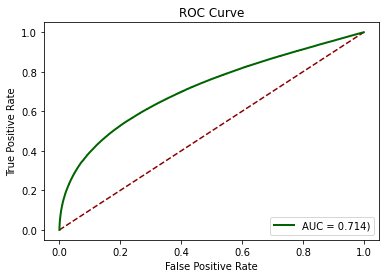

In [571]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred)

plt.plot([0, 1], [0, 1], color = 'darkred', linestyle = '--')
plt.plot(fpr, tpr, c='darkgreen', linewidth=2, label='AUC = %0.3f)' % sklearn.metrics.roc_auc_score(y_test, y_pred))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### Final prediction

In [572]:
X_final = latest_orders[{'order_number', 'order_dow', 'order_hour', 'basket_size', 'reorder_share'}]

yhat = result.predict(X_final)

In [573]:
prediction_index = prediction_index.set_index('user_id')
prediction_index['yhat'] = yhat
prediction_index

,order_number,yhat
user_id,,
1,11,0.715952
2,15,0.757079
3,13,0.735932
4,6,0.639685
5,5,0.597285
...,...,...
206205,4,0.585192
206206,68,0.993846
206207,17,0.780429


In [585]:
prediction_index.to_parquet('e02-group32.parquet')

### Better suited scoring metrics

Binary cross entropy / log loss is preferable, because the output is continuous and it is penalizing particularly inaccuracte predictions. 

Alternatively the Brier score / MSE could be pratical, because it is bounded between 0 and 1.

In [593]:
sklearn.metrics.log_loss(y_test, y_pred)

0.5033978152870241

In [586]:
sklearn.metrics.brier_score_loss(y_test, y_pred)

0.16815226023081847